# LSTM for MICEX bond spreads

In [57]:
import random
random.seed(42)
import numpy as np
import pandas as pd 
from pandas import DataFrame
#dealing with dataframes
from pandas import read_csv
#reading source .csv
from pandas import datetime 
#parsing dates in the source file
from pandas import Series 
#time series framework
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from matplotlib import pyplot as plt 
from numpy import log, sqrt

## Mock data for architecture testing

In [58]:
def simulate_series(n):
    np.random.seed(42)
    datalist = []
    for i in range(n):
        datalist.append(i*10+np.random.normal(0,10,1)[0])
    return np.array(datalist)

In [59]:
def simulate_series1(n):
    np.random.seed(42)
    datalist = []
    for i in range(n):
        datalist.append(i*10+100*np.sin(i))
    return np.array(datalist)

In [ ]:
mock_series = simulate_series(100)
mock_series

In [ ]:
mock_series1 = simulate_series1(100)
mock_series1

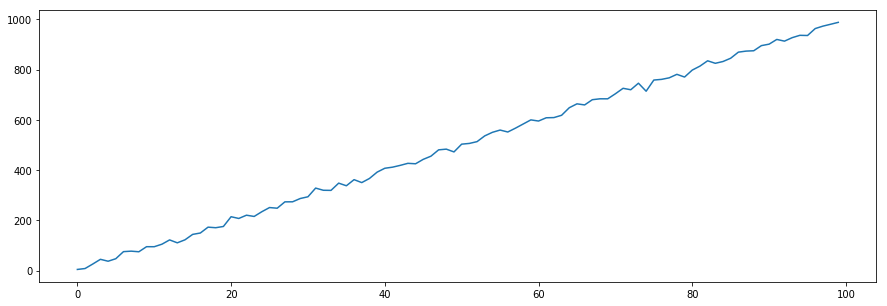

In [62]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
plt.plot(mock_series)
plt.show()

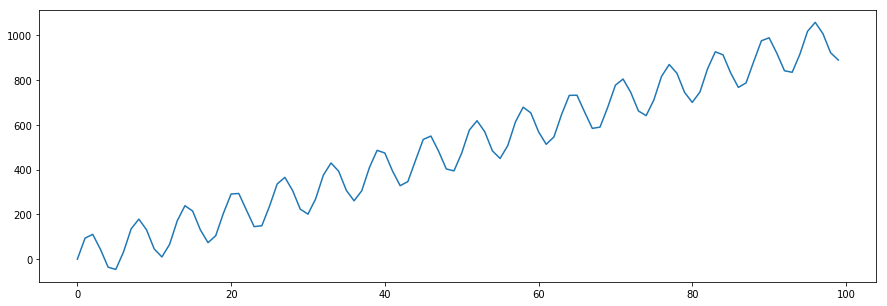

In [63]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
plt.plot(mock_series1)
plt.show()

## Mock static

In [66]:
np.random.seed(42)
training_set = 0.7
print(int(training_set * len(mock_series)))

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def mock_lstm_static(mock_series, lags_mock = 5, epochs = 200):
    
    # define tain and test series
    mock_series_train = mock_series[:int(training_set * len(mock_series))]
    mock_series_test = mock_series[int(training_set * len(mock_series)):]
    
    # define observed and predicted lists
    yhat_list = []
    observed_list = []
    
    # define plot of observed values in test
    test_plot = [c for c in mock_series_test]
    
    # reshape test series into a single column
    mock_series_train_prepared = mock_series_train.reshape(-1,1)
    
    # reframe data into ml-problem
    mock_train_x, mock_train_y = create_dataset(mock_series_train_prepared, lags_mock)
    
    # define model
    n_features = 1 # weak-form
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # reshape input for model fitting from [samples, timesteps] into [samples, timesteps, features]

    n_features = 1
    #print(mock_train_x.shape)
    mock_train_x = mock_train_x.reshape((mock_train_x.shape[0], mock_train_x.shape[1], n_features))
    #print(mock_train_x.shape)
    #print(mock_train_y.shape)
    
    # fit model
    model.fit(mock_train_x, mock_train_y, epochs=epochs, verbose=0)
    
    for t in range(len(mock_series_test)):
        
        # generate an input sequence
        x_input = []
        s = int(training_set * len(mock_series)) + t
        for i in range(1, lags_mock+1):
            x_input.append(mock_series[s-i])
        x_input = np.flip(np.array(x_input), axis = 0)
        #print("X_input = " + str(x_input))
        #print("Last true test value = " + str(mock_series_test[t-1]))
        
        
        # predict using derived input sequence
        x_input = x_input.reshape((1, lags_mock, n_features))
        yhat = model.predict(x_input, verbose=0)
        
        yhat_list.append(yhat[0,0])
        
        # get observed values
        obs = mock_series_test[t]
        observed_list.append(obs)
        
        #print('predicted=%f, expected=%f' % (yhat, obs))
        
    # get MSE
    error = mean_squared_error(observed_list, yhat_list)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)
    
    #get plots
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(test_plot)
    plt.plot(yhat_list, color='red')
    plt.show()

70


Test MSE: 297.529
Test RMSE: 17.249


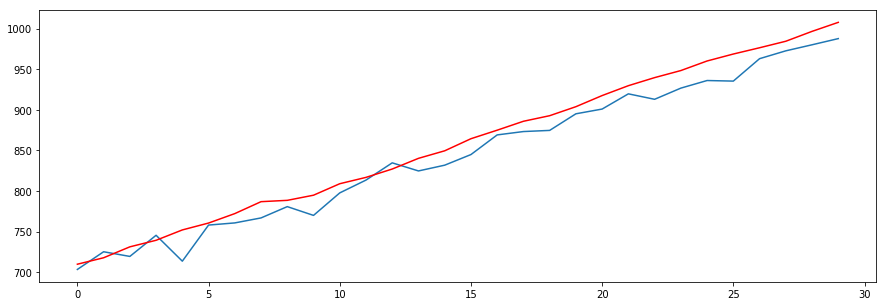

In [67]:
mock_lstm_static(mock_series, lags_mock = 5, epochs = 500)

Test MSE: 1768.343
Test RMSE: 42.052


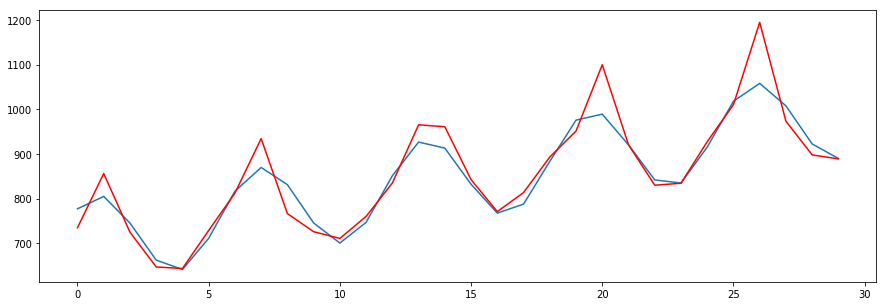

In [68]:
mock_lstm_static(mock_series1, lags_mock = 10, epochs = 1000)

## Mock rolling

In [69]:
np.random.seed(42)
training_set = 0.7
print(int(training_set * len(mock_series)))

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def mock_lstm_rolling(mock_series, lags_mock = 5, epochs = 200):
    
    # define tain and test series
    mock_series_train = mock_series[:int(training_set * len(mock_series))]
    mock_series_test = mock_series[int(training_set * len(mock_series)):]
    
    # define observed and predicted lists
    yhat_list = []
    observed_list = []
    
    # define plot of observed values in test
    test_plot = [c for c in mock_series_test]
    
    # define history list
    history = [h for h in mock_series_train]
    
    # define the model
    n_features = 1 # weak-form
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    
    for t in range(len(mock_series_test)):
        
        # prepare history list for recalibration
        history_prepared = np.array(history)
        history_prepared = history_prepared.reshape(-1,1)
        
        #recalibrate history into ML-type dataset
        history_x, history_y = create_dataset(history_prepared, lags_mock)
        
        #reshape history from [samples, timesteps] into [samples, timesteps, features]
        #print(history_x.shape)
        history_x = history_x.reshape((history_x.shape[0], history_x.shape[1], n_features))
        #print(history_x.shape)
        #print(history_y.shape)
        
        # fit the model
        model.fit(history_x, history_y, epochs=epochs, verbose=0, batch_size=32)
        
        history.append(mock_series_test[t])
        
        # generate an input sequence
        x_input = []
        s = int(training_set * len(mock_series)) + t
        for i in range(1, lags_mock+1):
            x_input.append(mock_series[s-i])
        x_input = np.flip(np.array(x_input), axis = 0)
        #print("X_input = " + str(x_input))
        #print("Last true test value = " + str(mock_series_test[t-1]))
        
        
        # predict using derived input sequence
        x_input = x_input.reshape((1, lags_mock, n_features))
        yhat = model.predict(x_input, verbose=0)
        
        yhat_list.append(yhat[0,0])
        
        # get observed values
        obs = mock_series_test[t]
        observed_list.append(obs)
        
        #print('predicted=%f, expected=%f' % (yhat, obs))
        
    # get MSE
    error = mean_squared_error(observed_list, yhat_list)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)
    
    #get plots
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(test_plot)
    plt.plot(yhat_list, color='red')
    plt.show()

70


Test MSE: 215.755
Test RMSE: 14.689


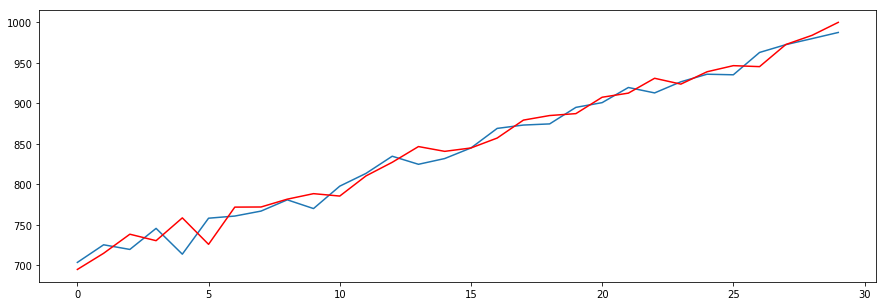

In [70]:
mock_lstm_rolling(mock_series, lags_mock = 1, epochs = 200)

Seems to be better than stationary model: MSE = 209 vs MSE = 265, RMSE = 14.4 vs RMSE = 16.3

Test MSE: 448.003
Test RMSE: 21.166


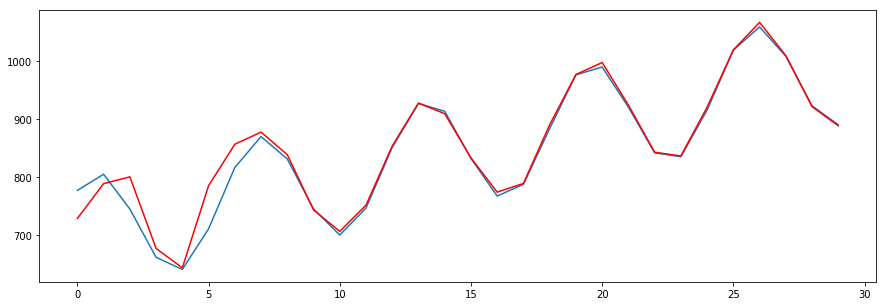

In [71]:
mock_lstm_rolling(mock_series1, lags_mock = 10, epochs = 500)

Is better than stationary model: MSE = 252 vs MSE = 2681, RMSE = 51 vs RMSE = 15.888

# Bond spreads

In [7]:
def date_parser(x):
    return datetime.strptime(x,'%d.%m.%Y')
df0 = read_csv('Spreads_BP.csv', sep=';', header=0, parse_dates=[1], index_col=1, squeeze=True, date_parser=date_parser, decimal=",")
df0.head()
df1 = df0.mask((df0 - df0.mean()).abs() > 3 * df0.std()).dropna()
df1.describe()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
count,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000
mean,1017.094671,162.384377,122.041386,151.513709,161.231764,127.979307,114.778065,147.852561,94.489224,122.926922,150.363994,175.418065,199.761619,100.463311,100.457346
std,588.868514,136.322510,98.629519,120.046547,171.203918,141.741321,139.316766,159.496300,78.705158,77.035318,74.060219,70.781496,67.631125,1.458056,0.305577
min,16.000000,-133.000000,-111.000000,-119.000000,-238.000000,-208.000000,-198.000000,-263.000000,13.210000,35.810000,54.400000,78.050000,101.950000,97.610000,99.460000
25%,499.000000,47.000000,38.000000,58.000000,22.000000,7.000000,-2.000000,18.000000,40.090000,68.860000,95.940000,121.120000,145.950000,99.540000,100.290000
50%,1046.000000,152.000000,118.000000,136.000000,152.000000,123.000000,111.000000,134.000000,68.230000,98.740000,126.320000,148.500000,176.480000,100.390000,100.440000
75%,1535.000000,271.000000,201.000000,256.000000,303.000000,229.000000,221.000000,259.000000,114.970000,154.050000,185.580000,214.650000,239.080000,101.010000,100.620000
max,2022.000000,513.000000,386.000000,476.000000,569.000000,503.000000,487.000000,537.000000,432.990000,442.230000,447.940000,453.100000,457.740000,103.700000,101.280000


In [8]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['ABSPR'] #set the one you need

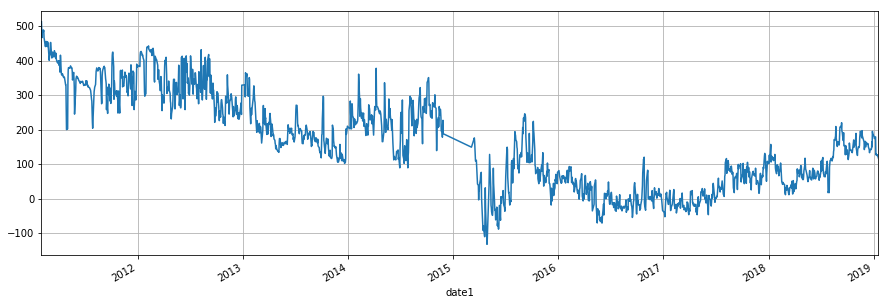

In [9]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True)

In [11]:
lags_mock = 5

In [12]:
np.random.seed(42)
training_set = 0.7
print(int(training_set * len(candidate_series)))

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def pd_series_lstm_static(mock_series, lags_mock = 5, epochs = 200):
    
    mock_series = np.array(mock_series.values)
    
    # define tain and test series
    mock_series_train = mock_series[:int(training_set * len(mock_series))]
    mock_series_test = mock_series[int(training_set * len(mock_series)):]
    
    # define observed and predicted lists
    yhat_list = []
    observed_list = []
    
    # define plot of observed values in test
    test_plot = [c for c in mock_series_test]
    
    # reshape test series into a single column
    mock_series_train_prepared = mock_series_train.reshape(-1,1)
    
    # reframe data into ml-problem
    mock_train_x, mock_train_y = create_dataset(mock_series_train_prepared, lags_mock)
    
    # define model
    n_features = 1 # weak-form
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    # reshape input for model fitting from [samples, timesteps] into [samples, timesteps, features]

    n_features = 1
    print(mock_train_x.shape)
    mock_train_x = mock_train_x.reshape((mock_train_x.shape[0], mock_train_x.shape[1], n_features))
    print(mock_train_x.shape)
    print(mock_train_y.shape)
    
    # fit model
    model.fit(mock_train_x, mock_train_y, epochs=epochs, batch_size=len(mock_series_test), verbose=2, shuffle = False)
    #len(mock_series_test)
    
    for t in range(len(mock_series_test)):
        
        # generate an input sequence
        x_input = []
        s = int(training_set * len(mock_series)) + t
        for i in range(1, lags_mock+1):
            x_input.append(mock_series[s-i])
        x_input = np.flip(np.array(x_input), axis = 0)
        
        
        # predict using derived input sequence
        x_input = x_input.reshape((1, lags_mock, n_features))
        yhat = model.predict(x_input, verbose=0)
        
        yhat_list.append(yhat[0,0])
        
        # get observed values
        obs = mock_series_test[t]
        observed_list.append(obs)
        
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    # get MSE
    error = mean_squared_error(observed_list, yhat_list)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)
    
    #get plots
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(test_plot)
    plt.plot(yhat_list, color='red')
    plt.show()

1353


In [ ]:
pd_series_lstm_static(candidate_series, lags_mock = 1, epochs = 500)

## Dataframe static

In [14]:
np.random.seed(42)
training_set = 0.7
print(int(training_set * len(candidate_series)))

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def pd_df_lstm_static(dataframe, lags_mock = 5, epochs = 200):
    
    df_results = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set): , ]})
    df_resids_test = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set): , ]})
    rmse_list = []
    col_list = []
    
    for column in range(1,8):
        dataset = dataframe.iloc[:,column]
        
        
        resid_test = []
        time_stamp = []
        
        mock_series = dataset
        
        test_w_index = mock_series[int(training_set * len(mock_series)):]
        
        mock_series = np.array(mock_series.values)
        
    
        # define tain and test series
        mock_series_train = mock_series[:int(training_set * len(mock_series))]
        mock_series_test = mock_series[int(training_set * len(mock_series)):]
    
        # define observed and predicted lists
        yhat_list = []
        observed_list = []
    
        # define plot of observed values in test
        test_plot = [c for c in mock_series_test]
    
        # reshape test series into a single column
        mock_series_train_prepared = mock_series_train.reshape(-1,1)
    
        # reframe data into ml-problem
        mock_train_x, mock_train_y = create_dataset(mock_series_train_prepared, lags_mock)
        
        # define model
        n_features = 1 # weak-form
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
    
        # reshape input for model fitting from [samples, timesteps] into [samples, timesteps, features]

        n_features = 1
        print(mock_train_x.shape)
        mock_train_x = mock_train_x.reshape((mock_train_x.shape[0], mock_train_x.shape[1], n_features))
        print(mock_train_x.shape)
        print(mock_train_y.shape)
    
        # fit model
        model.fit(mock_train_x, mock_train_y, epochs=epochs, batch_size=len(mock_series_test), verbose=2, shuffle = False)
    
        for t in range(len(mock_series_test)):
        
            # generate an input sequence
            x_input = []
            s = int(training_set * len(mock_series)) + t
            for i in range(1, lags_mock+1):
                x_input.append(mock_series[s-i])
            x_input = np.flip(np.array(x_input), axis = 0)
        
        
            # predict using derived input sequence
            x_input = x_input.reshape((1, lags_mock, n_features))
            yhat = model.predict(x_input, verbose=0)
        
            yhat_list.append(yhat[0,0])
        
            # get observed values
            obs = mock_series_test[t]
            observed_list.append(obs)
        
            #print('predicted=%f, expected=%f' % (yhat, obs))
            
            resid_test.append(int(yhat[0,0] - obs))
            time_stamp.append(dataframe['t'].iloc[int(len(dataframe['t']) * training_set): , ])
        
        # get MSE
        error = mean_squared_error(observed_list, yhat_list)
        rmse = sqrt(error)
        print('Test MSE: %.3f' % error)
        print('Test RMSE: %.3f' % rmse)
        
        col_list.append(column)
        rmse_list.append(rmse)
    
        #get plots
        plt.rcParams['figure.figsize'] = (15, 5)
        plt.plot(test_plot)
        plt.plot(yhat_list, color='red')
        plt.show()
        
        df_expected_col = pd.DataFrame(
            {'date1': test_w_index.index.values,
             'True': observed_list,
             'pred': yhat_list
            })
        df_expected_col.set_index('date1', inplace = True)
        print(df_expected_col.head())
        
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        #print(list(test.index.values))
        
        df_resid_col = pd.DataFrame(
            {'date1': test_w_index.index.values,
             'resid_test': resid_test
            })
        df_resid_col.set_index('date1', inplace = True)
        print(df_resid_col.head())
        
        df_resids_test = df_resids_test.join(df_resid_col, how = "outer", rsuffix = "_"+str(column))
        print(df_resids_test.head())
        
    df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        
        
    return df_results, df_resids_test, df_rmse

1353


In [ ]:
df_oos_expected_st_lstm, df_oos_resids_st_lstm, df_rmse_st_lstm = pd_df_lstm_static(df1, lags_mock = 1, epochs = 200)

In [16]:
df_rmse_st_lstm

,Series,RMSE
0,1,18.576366
1,2,35.347708
2,3,20.167953
3,4,17.545576
4,5,19.043239
5,6,21.460690
6,7,20.068318


In [17]:
df_oos_expected_st_lstm.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,6.360271,56.0,84.963768,-18.0,6.817461,-24.0,1.771208,-46.0,-19.765640,-70.0,-48.428860,-20.0,2.323879
2016-09-29,1440,-42.0,-17.368814,23.0,55.434456,-40.0,-14.585341,-48.0,-24.201111,-68.0,-43.735245,-89.0,-67.581924,-44.0,-18.762333
2016-09-30,1441,-45.0,-35.876495,24.0,20.771105,-42.0,-33.294144,-53.0,-47.489719,-80.0,-64.204369,-109.0,-83.168808,-48.0,-41.572868
2016-10-03,1442,12.0,-38.091213,95.0,21.711847,15.0,-34.827469,4.0,-52.683891,-26.0,-75.369347,-55.0,-98.749283,6.0,-45.413002
2016-10-04,1443,-13.0,8.409486,71.0,99.795395,-10.0,8.959880,-21.0,1.771208,-49.0,-21.855896,-79.0,-55.862175,-17.0,3.741768


In [18]:
df_oos_resids_st_lstm.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,26,28,24,25,26,21,22
2016-09-29,1440,24,32,25,23,24,21,25
2016-09-30,1441,9,-3,8,5,15,25,6
2016-10-03,1442,-50,-73,-49,-56,-49,-43,-51
2016-10-04,1443,21,28,18,22,27,23,20


In [19]:
df_rmse_st_lstm.to_csv('1_df_rmse_st_lstm.csv', index=True)
df_oos_expected_st_lstm.to_csv('1_df_oos_expected_st_lstm.csv', index=True)
df_oos_resids_st_lstm.to_csv('1_df_oos_resids_st_lstm.csv', index=True)

## Series rolling

In [20]:
def date_parser(x):
    return datetime.strptime(x,'%d.%m.%Y')
df0 = read_csv('Spreads_BP.csv', sep=';', header=0, parse_dates=[1], index_col=1, squeeze=True, date_parser=date_parser, decimal=",")
df0.head()
df1 = df0.mask((df0 - df0.mean()).abs() > 3 * df0.std()).dropna()
df1.describe()

,t,ABSPR,1YLSPR,1T3YSPR,3T5YSPR,BBBABSPR,BBB1T3SPR,BBB3T5SPR,CDS1Y,CDS2Y,CDS3Y,CDS4Y,CDS5Y,CLI SADJ,CPI
count,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000,1933.000000
mean,1017.094671,162.384377,122.041386,151.513709,161.231764,127.979307,114.778065,147.852561,94.489224,122.926922,150.363994,175.418065,199.761619,100.463311,100.457346
std,588.868514,136.322510,98.629519,120.046547,171.203918,141.741321,139.316766,159.496300,78.705158,77.035318,74.060219,70.781496,67.631125,1.458056,0.305577
min,16.000000,-133.000000,-111.000000,-119.000000,-238.000000,-208.000000,-198.000000,-263.000000,13.210000,35.810000,54.400000,78.050000,101.950000,97.610000,99.460000
25%,499.000000,47.000000,38.000000,58.000000,22.000000,7.000000,-2.000000,18.000000,40.090000,68.860000,95.940000,121.120000,145.950000,99.540000,100.290000
50%,1046.000000,152.000000,118.000000,136.000000,152.000000,123.000000,111.000000,134.000000,68.230000,98.740000,126.320000,148.500000,176.480000,100.390000,100.440000
75%,1535.000000,271.000000,201.000000,256.000000,303.000000,229.000000,221.000000,259.000000,114.970000,154.050000,185.580000,214.650000,239.080000,101.010000,100.620000
max,2022.000000,513.000000,386.000000,476.000000,569.000000,503.000000,487.000000,537.000000,432.990000,442.230000,447.940000,453.100000,457.740000,103.700000,101.280000


In [21]:
#List of series: ABSPR, 1YLSPR, 1T3YSPR, 3T5YSPR, BBBABSPR, BBB1T3SPR, BBB3T5SPR
candidate_series = df1['ABSPR'] #set the one you need

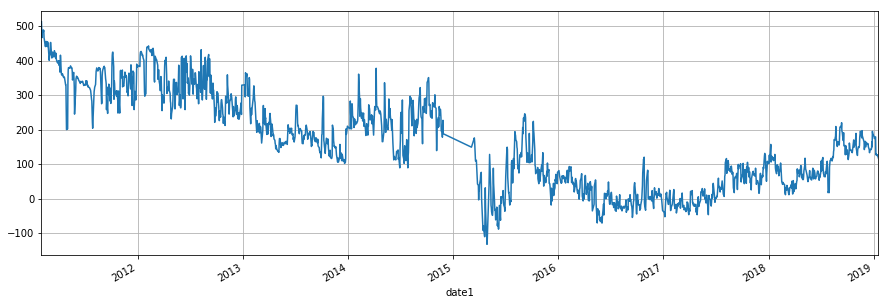

In [22]:
plt.rcParams['figure.figsize'] = (15, 5) #plot size
candidate_series.plot(grid=True)

In [23]:
np.random.seed(42)
training_set = 0.99

In [24]:

print(str(len(candidate_series) - int(training_set * len(candidate_series))))

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

def series_lstm_rolling(mock_series, lags_mock = 5, epochs = 200):
    
    # extract np array from pd series
    mock_series = np.array(mock_series.values)
    
    # define train and test series
    mock_series_train = mock_series[:int(training_set * len(mock_series))]
    mock_series_test = mock_series[int(training_set * len(mock_series)):]
    print(len(mock_series_test))
    
    # define observed and predicted lists
    yhat_list = []
    observed_list = []
    
    # define plot of observed values in test
    test_plot = [c for c in mock_series_test]
    
    # define history list
    history = [h for h in mock_series_train]
    
    # define the model
    n_features = 1 # weak-form
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    
    
    for t in range(len(mock_series_test)):
        
        print(str(t) + " out of " + str(len(mock_series_test)))
        
        # prepare history list for recalibration
        history_prepared = np.array(history)
        history_prepared = history_prepared.reshape(-1,1)
        
        #recalibrate history into ML-type dataset
        history_x, history_y = create_dataset(history_prepared, lags_mock)
        
        #reshape history from [samples, timesteps] into [samples, timesteps, features]
        print(history_x.shape)
        history_x = history_x.reshape((history_x.shape[0], history_x.shape[1], n_features))
        print(history_x.shape)
        print(history_y.shape)
        
        # fit the model
        model.fit(history_x, history_y, epochs=epochs, verbose=2, batch_size=512, shuffle = False)
        
        history.append(mock_series_test[t])
        
        # generate an input sequence
        x_input = []
        s = int(training_set * len(mock_series)) + t
        for i in range(1, lags_mock+1):
            x_input.append(mock_series[s-i])
        x_input = np.flip(np.array(x_input), axis = 0)
        print("X_input = " + str(x_input))
        print("Last true test value = " + str(mock_series_test[t-1]))
        
        
        # predict using derived input sequence
        x_input = x_input.reshape((1, lags_mock, n_features))
        yhat = model.predict(x_input, verbose=0)
        
        yhat_list.append(yhat[0,0])
        
        # get observed values
        obs = mock_series_test[t]
        observed_list.append(obs)
        
        print('predicted=%f, expected=%f' % (yhat, obs))
        
    # get MSE
    error = mean_squared_error(observed_list, yhat_list)
    rmse = sqrt(error)
    print('Test MSE: %.3f' % error)
    print('Test RMSE: %.3f' % rmse)
    
    #get plots
    plt.rcParams['figure.figsize'] = (15, 5)
    plt.plot(test_plot)
    plt.plot(yhat_list, color='red')
    plt.show()

20


In [ ]:
series_lstm_rolling(candidate_series, lags_mock = 1, epochs = 200)

# Dataframe rolling

In [49]:
np.random.seed(42)
training_set = 0.7

def create_dataset(dataset, look_back=lags_mock):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


def pd_df_lstm_rolling(dataframe, lags_mock = 5, epochs = 200):
    
    df_results = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set): , ]})
    df_resids_test = pd.DataFrame({'Time_step': df1['t'].iloc[int(len(df1['t']) * training_set): , ]})
    rmse_list = []
    col_list = []
    
    for column in range(1,8):
        dataset = dataframe.iloc[:,column]
        
        
        resid_test = []
        time_stamp = []
        
        mock_series = dataset
        
        test_w_index = mock_series[int(training_set * len(mock_series)):]
        
        mock_series = np.array(mock_series.values)
        
    
        # define tain and test series
        mock_series_train = mock_series[:int(training_set * len(mock_series))]
        mock_series_test = mock_series[int(training_set * len(mock_series)):]
    
        # define observed and predicted lists
        yhat_list = []
        observed_list = []
    
        # define plot of observed values in test
        test_plot = [c for c in mock_series_test]
        
        # define history list
        history = [h for h in mock_series_train]
    
        # define model
        n_features = 1 # weak-form
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(lags_mock, n_features)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        print("Column "+str(column))
    
            
        
        for t in range(len(mock_series_test)):
            
            print(str(t+1)+ " out of "+ str(len(mock_series_test)))
            
            # reshape history into a single column
            history_prepared = np.array(history)
            history_prepared = history_prepared.reshape(-1,1)
            
            # reframe data into ml-problem
            history_x, history_y = create_dataset(history_prepared, lags_mock)
            
            #reshape history from [samples, timesteps] into [samples, timesteps, features]
            #print(history_x.shape)
            history_x = history_x.reshape((history_x.shape[0], history_x.shape[1], n_features))
            #print(history_x.shape)
            #print(history_y.shape)
            
            # fit the model
            model.fit(history_x, history_y, epochs=epochs, verbose=0, batch_size=512, shuffle = False)
            
            # generate an input sequence
            x_input = []
            s = int(training_set * len(mock_series)) + t
            for i in range(1, lags_mock+1):
                x_input.append(mock_series[s-i])
            x_input = np.flip(np.array(x_input), axis = 0)
        
        
            # predict using derived input sequence
            x_input = x_input.reshape((1, lags_mock, n_features))
            yhat = model.predict(x_input, verbose=0)
        
            yhat_list.append(yhat[0,0])
        
            # get observed values
            obs = mock_series_test[t]
            observed_list.append(obs)
        
            #print('predicted=%f, expected=%f' % (yhat, obs))
            
            resid_test.append(int(yhat[0,0] - obs))
            time_stamp.append(dataframe['t'].iloc[int(len(dataframe['t']) * training_set): , ])
        
        # get MSE
        error = mean_squared_error(observed_list, yhat_list)
        rmse = sqrt(error)
        print('Test MSE: %.3f' % error)
        print('Test RMSE: %.3f' % rmse)
        
        col_list.append(column)
        rmse_list.append(rmse)
    
        #get plots
        plt.rcParams['figure.figsize'] = (15, 5)
        plt.plot(test_plot)
        plt.plot(yhat_list, color='red')
        plt.show()
        
        df_expected_col = pd.DataFrame(
            {'date1': test_w_index.index.values,
             'True': observed_list,
             'pred': yhat_list
            })
        df_expected_col.set_index('date1', inplace = True)
        print(df_expected_col.head())
        
        df_results = df_results.join(df_expected_col, how = "outer", rsuffix = "_"+str(column))
        #print(list(test.index.values))
        
        df_resid_col = pd.DataFrame(
            {'date1': test_w_index.index.values,
             'resid_test': resid_test
            })
        df_resid_col.set_index('date1', inplace = True)
        print(df_resid_col.head())
        
        df_resids_test = df_resids_test.join(df_resid_col, how = "outer", rsuffix = "_"+str(column))
        print(df_resids_test.head())
        
    df_rmse = pd.DataFrame(
            {'Series': col_list,
             'RMSE': rmse_list
            })
        
        
    return df_results, df_resids_test, df_rmse

In [ ]:
df_oos_expected_rolling_lstm, df_oos_resids_rolling_lstm, df_rmse_rolling_lstm = pd_df_lstm_rolling(df1, lags_mock = 1, epochs = 200)

In [53]:
df_rmse_rolling_lstm

,Series,RMSE
0,1,18.558535
1,2,36.845216
2,3,20.239422
3,4,17.934450
4,5,20.710688
5,6,22.317867
6,7,21.814945


In [54]:
df_oos_expected_rolling_lstm.head()

,Time_step,True,pred,True_2,pred_2,True_3,pred_3,True_4,pred_4,True_5,pred_5,True_6,pred_6,True_7,pred_7
date1,,,,,,,,,,,,,,,
2016-09-28,1439,-20.0,6.037911,56.0,86.612457,-18.0,8.380425,-24.0,2.785697,-46.0,-20.453489,-70.0,-47.321877,-20.0,3.065578
2016-09-29,1440,-42.0,-19.055460,23.0,60.875877,-40.0,-14.259670,-48.0,-18.211948,-68.0,-44.775169,-89.0,-67.027794,-44.0,-24.462461
2016-09-30,1441,-45.0,-34.489906,24.0,28.145119,-42.0,-32.732262,-53.0,-40.957733,-80.0,-65.796677,-109.0,-82.760872,-48.0,-40.735710
2016-10-03,1442,12.0,-34.188011,95.0,29.658720,15.0,-34.714378,4.0,-46.241093,-26.0,-76.914284,-55.0,-99.289764,6.0,-41.303143
2016-10-04,1443,-13.0,9.103573,71.0,102.146011,-10.0,4.686527,-21.0,10.058049,-49.0,-24.268661,-79.0,-53.961731,-17.0,14.143277


In [55]:
df_oos_resids_rolling_lstm.head()

,Time_step,resid_test,resid_test_2,resid_test_3,resid_test_4,resid_test_5,resid_test_6,resid_test_7
date1,,,,,,,,
2016-09-28,1439,26,30,26,26,25,22,23
2016-09-29,1440,22,37,25,29,23,21,19
2016-09-30,1441,10,4,9,12,14,26,7
2016-10-03,1442,-46,-65,-49,-50,-50,-44,-47
2016-10-04,1443,22,31,14,31,24,25,31


In [56]:
df_rmse_rolling_lstm.to_csv('1_df_rmse_rolling_lstm.csv', index=True)
df_oos_expected_rolling_lstm.to_csv('1_df_oos_expected_rolling_lstm.csv', index=True)
df_oos_resids_rolling_lstm.to_csv('1_df_oos_resids_rolling_lstm.csv', index=True)